#**Load Data**

In [1]:
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

df = pd.read_csv("/content/drive/MyDrive/All_Clickstream.csv", parse_dates=["Click Utc Ts"])

##**Question 1**
###**Frequent Visitors**

In [2]:
frequent_users = df["Profile Name"].value_counts().head(10)
print("Top Frequent Visitors:\n", frequent_users)


Top Frequent Visitors:
 Profile Name
User 5    3553
User 8    3331
User 7    2066
User 4    1433
User 0     933
User 6     468
User 3     306
User 2       8
User 1       6
Name: count, dtype: int64


##**Question 2**
###**Sessions and Page views**

In [3]:
df = df.sort_values(by=["Profile Name", "Click Utc Ts"])
df["TimeDiff"] = df.groupby("Profile Name")["Click Utc Ts"].diff().dt.total_seconds().fillna(0)
df["SessionId"] = (df["TimeDiff"] > 1800).cumsum()

# Aggregating sessions
sessions = df.groupby(["Profile Name", "SessionId"])["Navigation Level"].agg(list).reset_index()
print("\nSample Sessions:\n", sessions.head(5))


Sample Sessions:
   Profile Name  SessionId                                   Navigation Level
0       User 0          0  [accountMenu, accountMenu, accountMenu, browse...
1       User 0          1  [profilesGate, browseTitles, browseTitles, bro...
2       User 0          2  [playback, playback, movieDetails, movieDetail...
3       User 0          3                           [playback, movieDetails]
4       User 0          4  [accountMenu, accountMenu, accountMenu, browse...


##**Question 3**
###**Frequent Previous Pages**

In [4]:
df["PreviousPage"] = df.groupby(["Profile Name", "SessionId"])["Navigation Level"].shift(1)
frequent_previous = df.groupby("Navigation Level")["PreviousPage"].value_counts().head(5)
print("\nTop 5 Previous Pages:\n", frequent_previous)



Top 5 Previous Pages:
 Navigation Level  PreviousPage       
accountMenu       accountMenu            107
                  browseTitles            64
                  webLink                 12
                  settings                 9
                  browseTitlesGallery      7
Name: count, dtype: int64


##**Quesion 4**
###**Frequent Pagesets**

In [5]:
te = TransactionEncoder()
te_ary = te.fit(sessions["Navigation Level"]).transform(sessions["Navigation Level"])
transactions_df = pd.DataFrame(te_ary, columns=te.columns_)

# Itemsets with support >=25%
frequent_itemsets = apriori(transactions_df, min_support=0.25, use_colnames=True)
print("\nFrequent Itemsets (Support >=25%):\n", frequent_itemsets)


Frequent Itemsets (Support >=25%):
      support                                    itemsets
0   0.797521                              (browseTitles)
1   0.490083                              (movieDetails)
2   0.649587                                  (playback)
3   0.546281                              (profilesGate)
4   0.344628                (browseTitles, movieDetails)
5   0.516529                    (playback, browseTitles)
6   0.504959                (browseTitles, profilesGate)
7   0.378512                    (playback, movieDetails)
8   0.314050                (movieDetails, profilesGate)
9   0.381818                    (playback, profilesGate)
10  0.283471      (playback, browseTitles, movieDetails)
11  0.284298  (browseTitles, movieDetails, profilesGate)
12  0.351240      (playback, browseTitles, profilesGate)
13  0.260331      (playback, movieDetails, profilesGate)


##**Question 5**
###**Association Rules (Lift>=2.05)**

In [6]:

rules = association_rules(frequent_itemsets, metric="lift", min_threshold=2.05)
print("\nAssociation Rules (Lift >=2.05):\n", rules[["antecedents", "consequents", "support", "confidence", "lift"]])



Association Rules (Lift >=2.05):
 Empty DataFrame
Columns: [antecedents, consequents, support, confidence, lift]
Index: []


##**Question 6**
###**Sequential Pattern using the GSP-like approximation**

In [7]:

from itertools import combinations
all_sequences = sessions["Navigation Level"].tolist()

sequence_counts = {}
for seq in all_sequences:
    for i in range(len(seq)-1):
        pair = tuple(seq[i:i+2])
        sequence_counts[pair] = sequence_counts.get(pair, 0) + 1

# Filter sequences with support >=20%
total_sessions = len(sessions)
frequent_sequences = {k: v/total_sessions for k, v in sequence_counts.items() if v/total_sessions >= 0.2}
print("\nFrequent Sequential Patterns:\n", frequent_sequences)



Frequent Sequential Patterns:
 {('browseTitles', 'browseTitles'): 0.9239669421487603, ('browseTitles', 'search'): 0.22727272727272727, ('search', 'search'): 0.2537190082644628, ('search', 'movieDetails'): 0.23801652892561984, ('movieDetails', 'movieDetails'): 0.8570247933884297, ('movieDetails', 'playback'): 0.5677685950413223, ('playback', 'movieDetails'): 0.4396694214876033, ('profilesGate', 'browseTitles'): 0.5603305785123966, ('playback', 'playback'): 0.5198347107438016, ('browseTitles', 'movieDetails'): 0.4033057851239669, ('movieDetails', 'browseTitles'): 0.28429752066115704, ('browseTitles', 'playback'): 0.5016528925619834, ('playback', 'browseTitles'): 0.3752066115702479, ('playback', 'postPlay'): 0.24793388429752067, ('postPlay', 'playback'): 0.2}


##**Question 7**
###**User Clusters (K-Means)**

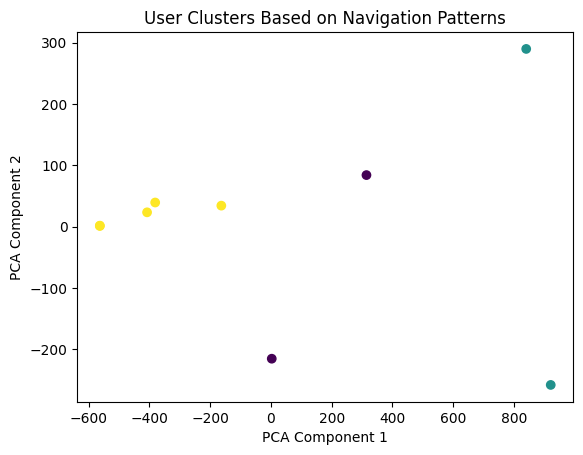

In [8]:
user_page_matrix = pd.crosstab(df["Profile Name"], df["Navigation Level"])

kmeans = KMeans(n_clusters=3)
clusters = kmeans.fit_predict(user_page_matrix)
user_page_matrix["Cluster"] = clusters

# PCA for 2D visualization
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(user_page_matrix.drop("Cluster", axis=1))

plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=user_page_matrix["Cluster"], cmap="viridis")
plt.title("User Clusters Based on Navigation Patterns")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()